In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import logging


In [4]:
import qt3utils.experiments.podmr
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

In [5]:
pulser = qcsapphire.Pulser('COM10')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [6]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [8]:
def aggregate_mean_data(data_buffer, experiment):
    '''
    Calls qt3utils.analysis.aggregation.reshape_sum_trace, where
        cwodmr.N_cycles = N_rows
        cwodmr.N_clock_ticks_per_cycle = N_samples_per_row

    '''
    return qt3utils.analysis.aggregation.reshape_mean_trace(data_buffer,
                                                           experiment.N_cycles,
                                                           experiment.N_clock_ticks_per_cycle)

In [9]:
logging.basicConfig(level=logging.WARNING)

In [10]:
qt3utils.experiments.podmr.logger.setLevel(logging.WARNING)

In [25]:
def recombine_scans(set_of_scans):
    combined_scans = {s[0]:np.zeros(s[1]) for s in set_of_scans[0]}

    for scan in set_of_scans:
        for read in scan:
            width = read[0]
            data = read[-1]
            combined_scans[width] += data

    reconstructed_scan = [[s, len(combined_scans[s]), combined_scans[s]] for s in sorted(list(combined_scans.keys()))]
    return reconstructed_scan

In [12]:
def plot_rolled_trace(trace, N_cycles=1, clock_rate=1, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate)

In [79]:
def signal_to_background(trace, pre_trigger, aom_width, rf_width, post_rf_pad, verbose=False,
                        signal_aom_width_duty = 1.0, background_aom_width_duty = 1.0,
                        aggregation = np.sum):
    '''
    Assumes trace produced by qt3utils.experiments.rabi.Rabi class and
    is the aggregated data for a particular RF width.

    The inputs `pre_trigger`, `aom_width` and `rf_width` are all in units of index of the trace.
    That is, they are in units of clock ticks.

    Assumes that trace is of shape
        * pre_trigger
        * aom_width: aom on / rf off (background)
        * rf_width:  aom off / rf on
        * aom_width: aom on/ rf off  (signal)

    returns sum(signal) / sum(background)

    '''
    background_end = pre_trigger + int(aom_width*background_aom_width_duty)
    signal_start = pre_trigger + aom_width + rf_width + post_rf_pad
    signal_end = signal_start + int(aom_width*signal_aom_width_duty)

    background = aggregation(trace[pre_trigger:background_end])
    signal = aggregation(trace[signal_start:signal_end])

    if verbose:
        print(f'inputs. pre_trigger = {pre_trigger}, aom_width = {aom_width}, rf_width = {rf_width}')
        print(f'        signal_duty = {signal_aom_width_duty}, bkgd_duty = {background_aom_width_duty}')
        print(f'        aggregation = {aggregation}')
        print(f'background: {pre_trigger} -> {background_end}')
        print(trace[pre_trigger:background_end])
        print(f'signal: {signal_start} -> {signal_end}')
        print(trace[signal_start:signal_end])

    return signal / background



In [89]:
def build_contrast(single_scan, clock_period, aom_width_time, rf_width_time, post_rf_pad, 
                   pre_trigger = 2, signal_duty=0.25, background_duty=0.25, verbose = False):

    contrast = []
    if verbose:
        print(clock_period)
        print(aom_width_time)
        print(post_rf_pad)
    for measurement in single_scan:
        
        rf_frequency = measurement[0]
        #N_samples_per_cycle = measurement[1]
        #clock_period = rabi.clock_period
        #aom_width_time = rabi.aom_width
        summed_trace = measurement[2]
 
        aom_width_ticks = int(aom_width_time / clock_period)
        rf_width_ticks = int(rf_width_time / clock_period)
        # post_rf_pad_ticks = np.round(rabi.post_rf_pad / clock_period).astype(int)
        post_rf_pad_ticks = int(post_rf_pad / clock_period)

        c = signal_to_background(summed_trace, 
                                 pre_trigger, 
                                 aom_width_ticks, 
                                 rf_width_ticks, 
                                 post_rf_pad_ticks,
                                 signal_aom_width_duty = signal_duty, 
                                 background_aom_width_duty = background_duty , aggregation = np.mean, verbose=verbose)

        contrast.append([rf_frequency, c]) 

    contrast = np.array(contrast)
    return contrast

In [127]:
experiment = qt3utils.experiments.podmr.PulsedODMR(pulser, rfsynth, nidaq_config, rf_width = .5e-6, rf_power = -30)

In [128]:
experiment.rfsynth.rf_on(experiment.rfsynth_channel)
time.sleep(2)
print(experiment.experimental_conditions())

full_scans = []

for i in range(50):
    if i % 5 == 0:
        print(i)
    scan_data = experiment.run(N_cycles=1000, post_process_function=aggregate_mean_data, reverse=(i%2==0))
    full_scans.append(scan_data)
    
    #scan_data = rabi.run(N_cycles = 100000, post_process_function=aggregate_mean_data)

{'freq_low': 2820000000.0, 'freq_high': 2920000000.0, 'freq_step': 1000000.0, 'rf_power': -30, 'rf_width': 5e-07, 'aom_width': 3e-06, 'aom_response_time': 8e-07, 'post_rf_pad': 1e-06, 'pre_rf_pad': 2e-07, 'clock_period': 2e-07}
0
5
10
15
20
25
30
35
40
45


In [129]:
reconstructed_single_scan = recombine_scans(full_scans)

In [130]:
def plot_rolled_trace(trace, N_cycles=1, clock_rate=1, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate)

In [131]:
scan

[2920000000.0,
 50,
 array([0.049, 0.224, 6.771, 6.835, 6.825, 6.855, 6.774, 6.818, 6.797,
        6.917, 6.802, 6.963, 6.8  , 6.785, 6.808, 6.735, 6.741, 0.315,
        0.055, 0.047, 0.059, 0.061, 0.052, 0.054, 0.054, 0.055, 0.199,
        6.592, 6.974, 6.75 , 6.754, 6.819, 6.869, 6.799, 6.795, 6.967,
        6.778, 6.945, 6.805, 6.766, 6.781, 6.606, 0.316, 0.067, 0.062,
        0.068, 0.065, 0.061, 0.055, 0.049])]

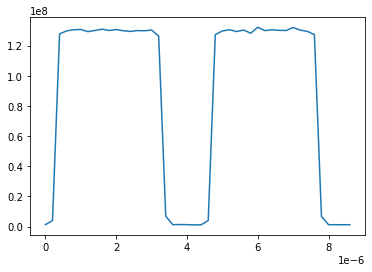

In [132]:
scan = reconstructed_single_scan[10]
plot_rolled_trace(scan[-1], clock_rate = 1/experiment.clock_period)

In [133]:
pre_trigger = 2
aom_width = int(experiment.aom_width / experiment.clock_period)
#rf_delay = int((experiment.aom_response_time  + experiment.pre_rf_pad)/experiment.clock_period)
rf_width = int(experiment.rf_width / experiment.clock_period)
post_rf_pad = int(experiment.post_rf_pad / experiment.clock_period)

print(aom_width)
#print(rf_delay)
print(rf_width)
print(post_rf_pad)
print(scan[-1])
print('function')

signal_to_background(scan[-1], pre_trigger, aom_width, rf_width, post_rf_pad, verbose=True)

15
2
5
[ 0.261  0.802 25.548 25.942 26.101 26.128 25.849 26.002 26.172 25.997
 26.118 25.967 25.871 25.986 25.963 26.061 25.258  1.378  0.253  0.276
  0.26   0.226  0.24   0.801 25.446 25.937 26.103 25.855 26.062 25.636
 26.428 25.984 26.092 26.014 26.    26.397 26.043 25.886 25.449  1.35
  0.252  0.253  0.249  0.252]
function
inputs. pre_trigger = 2, aom_width = 15, rf_width = 2
        signal_duty = 1.0, bkgd_duty = 1.0
        aggregation = <function sum at 0x000001BD27EBC700>
background: 2 -> 17
[25.548 25.942 26.101 26.128 25.849 26.002 26.172 25.997 26.118 25.967
 25.871 25.986 25.963 26.061 25.258]
signal: 24 -> 39
[25.446 25.937 26.103 25.855 26.062 25.636 26.428 25.984 26.092 26.014
 26.    26.397 26.043 25.886 25.449]


1.0009486763522495

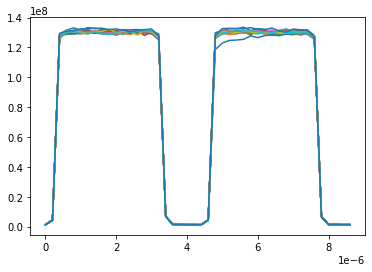

In [134]:
for scan in reconstructed_single_scan[::5]:
    plot_rolled_trace(scan[-1], clock_rate = 1/experiment.clock_period)

In [135]:
contrast = build_contrast(reconstructed_single_scan, experiment.clock_period, 
                          experiment.aom_width, experiment.rf_width,
                          experiment.post_rf_pad, signal_duty=.5, background_duty=.5)
x_data = contrast[:, 0]
y_data = contrast[:, 1]

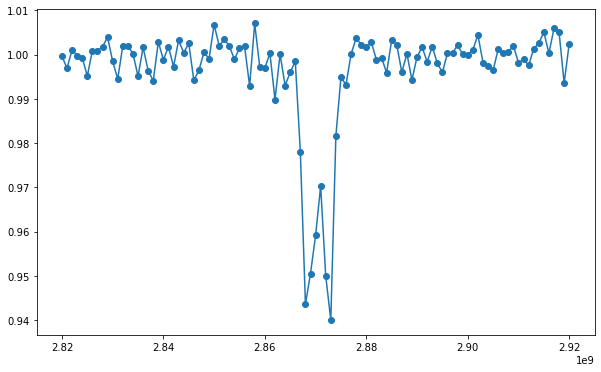

In [136]:


plt.figure(figsize=(10, 6))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

# plt.xlabel('microseconds')
# plt.ylabel('signal/background')
# plt.plot(x_data, rabi_oscillation(x_data, *params),
#          label='Fitted function', color='orange')
# plt.legend()

In [139]:
x_data[y_data<0.95]

array([2.868e+09, 2.873e+09])